# SEP 775 Assignment 4

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.models.t5.modeling_t5 import T5Attention
import math
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import gc
import sentencepiece
import keyword
import builtins
import re
import types
from pathlib import Path
import copy
from nltk.translate.bleu_score import corpus_bleu

C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Importing python-codes-25k Data, EDA, and Preprocessing

In [2]:
ins_to_code_df = pd.read_json("./python-codes-25k.json")

In [3]:
ins_to_code_df.head()

,instruction,input,output,text
0,Help me set up my daily to-do list!,Setting up your daily to-do list...,```python\ntasks = []\nwhile True:\n task =...,Help me set up my daily to-do list! Setting up...
1,Create a shopping list based on my inputs!,Creating a shopping list...,```python\nshopping_list = {}\nwhile True:\n ...,Create a shopping list based on my inputs! Cre...
2,Calculate how much time I spend on my phone pe...,Calculating weekly phone usage...,"```python\ntotal_time = 0\nfor i in range(1, 8...",Calculate how much time I spend on my phone pe...
3,Help me split the bill among my friends!,Splitting the bill...,```python\ntotal_bill = float(input('Enter the...,Help me split the bill among my friends! Split...
4,Organize my movie list into genres!,Organizing your movie list...,```python\nmovie_list = {}\nwhile True:\n g...,Organize my movie list into genres! Organizing...


In [4]:
ins_to_code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24813 entries, 0 to 24812
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  24813 non-null  object
 1   input        24813 non-null  object
 2   output       24813 non-null  object
 3   text         24813 non-null  object
dtypes: object(4)
memory usage: 775.5+ KB


The instruction column contains the natural language instruction from human about what the generated code should do. The input column contains short and introductive part of AI response or empty. The output column contains the Python code that accomplishes the task that need to be done for the instruction. The text column contains strings which are concatenations of all other 3 columns' values.

In [5]:
# Check length distribution of instructions/output code splitted by space
# to have a rough idea about how long the sequence of word embeddings could be
inst_len = [len(s.split()) for s in ins_to_code_df['instruction']]
code_len = [len(s.split()) for s in ins_to_code_df['output']]

C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


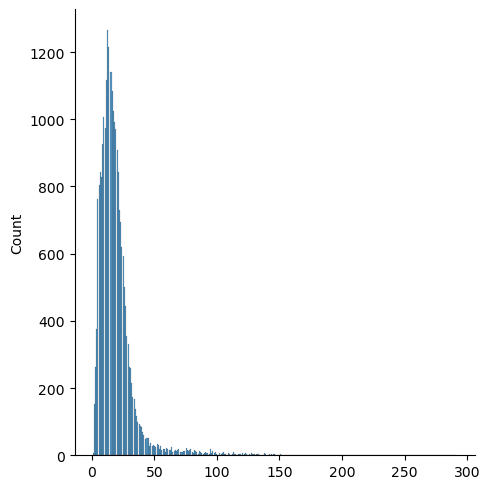

In [6]:
sns.displot(data=pd.Series(inst_len))

C:\Users\jimta\anaconda3\envs\NLP_env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


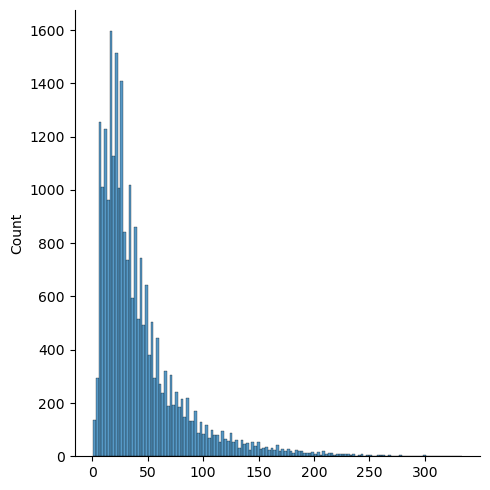

In [7]:
sns.displot(data=pd.Series(code_len))

All the lengths of instructions and code snippets are less than 300 when splitted by space, implying that most of the instructions and code snippets should be able to fit in the input length limit of the model (typically 512) after tokenization. 

To later encode the Python code snippets in output, each of the keywords and built-in functions in Python need to have a special token, since they have special meanings, and some of them are not in the natural language's vocabulary (e.g. def, del).

In [8]:
# Put strings of Python keywords and built-in functions' names into two lists
pyt_data_types = ['float','int','complex','bool','bytearray','bytes','filter','str','tuple','list','set','map',
                  'memoryview','dict','enumerate','frozenset','range','object','property','reversed',
                  'slice', 'classmethod','staticmethod','super','type','zip']
pyt_func_list = [name for name, obj in vars(builtins).items()
                 if (isinstance(obj, types.BuiltinFunctionType) or isinstance(obj, types.MethodType))]
pyt_func_list += pyt_data_types
pyt_kw_list = keyword.kwlist.copy()

# convert to special tokens by prefixing Python keywords with 'pytkw:' and built-in function names with 'pytfunc:'
pyt_kw_tok = ['pytkw:'+kw for kw in pyt_kw_list]
pyt_func_tok = ['pytfunc:'+func for func in pyt_func_list]

In [9]:
# Obtain pretrained T5-small model and tokenizer of pre-trained T5-small model
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
# Add the new tokens for keywords and built-in function names 
# and also some characters that are not in the tokenizer vocab (i.e. '\n','{', '}')into the tokenizer vocab
tokenizer.add_tokens(pyt_kw_tok)
tokenizer.add_tokens(pyt_func_tok)
tokenizer.add_tokens(['\n','{', '}'])

# Add new, random embeddings for the new tokens
model.resize_token_embeddings(len(tokenizer))

Embedding(32208, 512)

In [11]:
def preprocess_code_snippets(snippets, kw_list, built_in_func_list):
    """
    Function the preprocess Python code snippets by truncating leading and tailing substrings that contain no info
    and prefixing Python keywords and built-in function names with 'pytkw:' and 'pytfunc:'
    
    Parameters:
    snippets  list[str]: Python code snippets to be preprocessed
    kw_list list[str]: list of Python keywords need to be prefixed
    built_in_func_list list[str]: list of Python built-in function names need to be prefixed
    
    Output:
    preprocessed Python code snippets
    """
    preprocessed_snippets = []
    for code in snippets:
        # The code snippts always start with "'''python\n"  and end with "\n'''", which are useless parts that can be removed
        code = code[10:-4]
        # initialize lists to record the keywords and built-in function names found in the snippet 
        kw_in_code = []
        func_in_code = []
        # Find keywords
        for kw in kw_list:
            kw_in_code += re.findall(r"[^a-zA-Z0-9_]"+kw+r"[^a-zA-Z0-9_]",code)
        #print(kw_in_code)
        # add prefix to the keywords
        for kw_str in kw_in_code:
            code = code.replace(kw_str, kw_str[0]+'pytkw:'+kw_str[1:])
        
        # find built-in function names
        for func in built_in_func_list:
            func_in_code += re.findall(r"[^a-zA-Z0-9_]"+func+r"\(",code)
        #print(func_in_code)
        # add prefix to the built-in function names
        for func_str in func_in_code:
            code = code.replace(func_str, func_str[0]+'pytfunc:'+func_str[1:])
            
        preprocessed_snippets.append(code)
        
    return preprocessed_snippets
            

In [12]:
prerpocessed_output = preprocess_code_snippets(ins_to_code_df['output'].values, pyt_kw_list, pyt_func_list)

In [13]:
preprocessed_code_df = ins_to_code_df.drop(columns=['input','text'])
preprocessed_code_df['output'] = pd.Series(prerpocessed_output)

In [14]:
preprocessed_code_df.head()

,instruction,output
0,Help me set up my daily to-do list!,tasks = []\npytkw:while pytkw:True:\n task ...
1,Create a shopping list based on my inputs!,shopping_list = {}\npytkw:while pytkw:True:\n ...
2,Calculate how much time I spend on my phone pe...,total_time = 0\npytkw:for i pytkw:in pytfunc:r...
3,Help me split the bill among my friends!,total_bill = pytfunc:float(pytfunc:input('Ente...
4,Organize my movie list into genres!,movie_list = {}\npytkw:while pytkw:True:\n ...


In [189]:
#code_ids = tokenizer(preprocessed_code_df['output'][0], return_tensors="pt")
#print(code_ids.input_ids)
#print(tokenizer.convert_ids_to_tokens(code_ids.input_ids[0]))
#print(tokenizer.decode(code_ids.input_ids[0]))

## Tokenize the preprocessed dataset

In [17]:
class QADataset(Dataset):
    """
    Class for custom datset to be used for Dataloader later to split into batches
    """
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item

    def pad_data(self, data):
        QA_pairs = data
        questions =  [x[0] for x in QA_pairs]
        answers = [x[1] for x in QA_pairs]
        q_encoding = self.tokenizer(text=questions, return_tensors='pt', padding=True)
        q_token_ids = torch.LongTensor(q_encoding['input_ids'])
        #q_attention_mask = torch.LongTensor(q_encoding['attention_mask'])
        a_encoding = self.tokenizer(text=answers, return_tensors='pt', padding=True)
        a_token_ids = torch.LongTensor(a_encoding['input_ids'])
        #a_attention_mask = torch.LongTensor(a_encoding['attention_mask'])

        return q_token_ids, a_token_ids

    def collate_fn(self, all_data):
        q_token_ids, a_token_ids = self.pad_data(all_data)
        batched_data = {
            'q_token_ids': q_token_ids,
            'a_token_ids': a_token_ids,
        }

        return batched_data

In [18]:
def create_data(QA_df, Q_col, A_col, tokenizer, max_len=math.inf):
    """
    function to create the data which is a list of (instruction, output) from a dataframe
    """
    data = []
    num_of_QA = 0
    for i in QA_df.index:
        #if num_of_QA >= max_size:
        #    break

        row = QA_df.loc[i]
        instruction, output = row[Q_col], row[A_col]
        QA_pair = (instruction,output)

        tokenized_inst_len = len(tokenizer(text=instruction)['input_ids'])
        tokenized_output_len = len(tokenizer(text=output)['input_ids'])
        if (tokenized_inst_len >= max_len or tokenized_output_len >= max_len):
            #print(tokenized_inst_len)
            #print(tokenized_output_len)
            continue

        data.append(QA_pair)
        num_of_QA += 1

    print(f"loaded {len(data)} QA pairs")
    return data

In [19]:
inst_to_code_data = create_data(preprocessed_code_df, 'instruction', 'output', 
                                tokenizer, 512)

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


loaded 24774 QA pairs


In [20]:
# Split data into train, dev and test sets
# only take the first 15000 samples to save some time of training 
inst_to_code_train_data, dev_test_data = train_test_split(inst_to_code_data[:15000], test_size=0.3, random_state=42)
inst_to_code_dev_data, inst_to_code_test_data = train_test_split(dev_test_data, test_size=0.5, random_state=42)

In [22]:
inst_to_code_train_dataset = QADataset(inst_to_code_train_data, tokenizer)
inst_to_code_dev_dataset = QADataset(inst_to_code_dev_data, tokenizer)
inst_to_code_test_dataset = QADataset(inst_to_code_test_data, tokenizer)

In [23]:
#inst_to_code_loader = DataLoader(inst_to_code_dataset, shuffle=True, batch_size=128,
#                                 collate_fn=inst_to_code_dataset.collate_fn, drop_last=True)
#for step, batch in enumerate(inst_to_code_loader):
#    print(batch['q_token_ids'].size())
#    print(batch['a_token_ids'].size())

## Integration of LoRA and Model Fine-tuning

In [36]:
class LoraT5Attention(T5Attention):
    """
    Class that inherits from the standard T5Attention, but initializes and adds the LoRA matricies to its query and value matrices.

    The class overwrites the forward method with the new LoRA logic. 
    """
    def __init__(self, r=8, *args, **kwargs):
        """
        Function to initialize the new matricies needed for LoRA on T5 
        All of names of the new parameters in the new matrices start with "lora_" 
        which will be checked for this later in the full model wrapper to identify the lora parameters
        
        Parameters:
        r: the rank of the matricies for LoRA
        *args: The config of the T5 Model/Attention layer, has to be passed to work with super
        """
        super().__init__(*args, **kwargs)
        
        # Initialize matrices of trainable parameters for query and value vectors
        # B will be initialized with zeros, A with random Gaussian, such that their product BA and
        # thus the weight delta is zero at the beginning
        self.lora_Wq_matrix_B = nn.Parameter(torch.zeros(self.d_model, r))
        self.lora_Wq_matrix_A = nn.Parameter(torch.randn(r, self.inner_dim))
        self.lora_Wv_matrix_B = nn.Parameter(torch.zeros(self.d_model, r))
        self.lora_Wv_matrix_A = nn.Parameter(torch.randn(r, self.inner_dim))
        #print(self.relative_attention_bias)


    def lora_query(self, x):
        """
        Function to perform LoRA on query weight matrix. 
        """
        lora_full_query_weights = torch.matmul(self.lora_Wq_matrix_B, self.lora_Wq_matrix_A)
        return self.q(x) + F.linear(x, lora_full_query_weights)


    def lora_value(self, x):
        """
        Function to perform LoRA on value weight matrix. 
        """
        lora_full_value_weights = torch.matmul(self.lora_Wv_matrix_B, self.lora_Wv_matrix_A)
        return self.v(x) + F.linear(x, lora_full_value_weights)


    def forward(self, hidden_states, mask=None, key_value_states=None, position_bias=None,
                past_key_value=None, layer_head_mask=None, query_length=None, use_cache=False, 
                output_attentions=False):
        """
        Forward function copied from https://github.com/huggingface/transformers/blob/main/src/transformers/models/t5/modeling_t5.py#L349
        but replaced the self.q and self.v calls with calls to the lora_query and lora_value functions.
        """
        # Input is (batch_size, seq_length, dim)
        # Mask is (batch_size, key_length) (non-causal) or (batch_size, key_length, key_length)
        # past_key_value[0] is (batch_size, n_heads, q_len - 1, dim_per_head)
        batch_size, seq_length = hidden_states.shape[:2]

        real_seq_length = seq_length

        if past_key_value is not None:
            if len(past_key_value) != 2:
                raise ValueError(
                    f"past_key_value should have 2 past states: keys and values. Got { len(past_key_value)} past states"
                )
            real_seq_length += past_key_value[0].shape[2] if query_length is None else query_length

        key_length = real_seq_length if key_value_states is None else key_value_states.shape[1]

        def shape(states):
            """projection"""
            return states.view(batch_size, -1, self.n_heads, self.key_value_proj_dim).transpose(1, 2)

        def unshape(states):
            """reshape"""
            return states.transpose(1, 2).contiguous().view(batch_size, -1, self.inner_dim)

        def project(hidden_states, proj_layer, key_value_states, past_key_value):
            """projects hidden states correctly to key/query states"""
            if key_value_states is None:
                # self-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(hidden_states))
            elif past_key_value is None:
                # cross-attn
                # (batch_size, n_heads, seq_length, dim_per_head)
                hidden_states = shape(proj_layer(key_value_states))

            if past_key_value is not None:
                if key_value_states is None:
                    # self-attn
                    # (batch_size, n_heads, key_length, dim_per_head)
                    hidden_states = torch.cat([past_key_value, hidden_states], dim=2)
                elif past_key_value.shape[2] != key_value_states.shape[1]:
                    # checking that the `sequence_length` of the `past_key_value` is the same as
                    # the provided `key_value_states` to support prefix tuning
                    # cross-attn
                    # (batch_size, n_heads, seq_length, dim_per_head)
                    hidden_states = shape(proj_layer(key_value_states))
                else:
                    # cross-attn
                    hidden_states = past_key_value
            return hidden_states

        # get query states
        query_states = shape(self.lora_query(hidden_states))  # (batch_size, n_heads, seq_length, dim_per_head)

        # get key/value states
        key_states = project(
            hidden_states, self.k, key_value_states, past_key_value[0] if past_key_value is not None else None
        )
        value_states = project(
            hidden_states, self.lora_value, key_value_states, past_key_value[1] if past_key_value is not None else None
        )

        # compute scores
        scores = torch.matmul(
            query_states, key_states.transpose(3, 2)
        )  # equivalent of torch.einsum("bnqd,bnkd->bnqk", query_states, key_states), compatible with onnx op>9

        if position_bias is None:
            if not self.has_relative_attention_bias:
                position_bias = torch.zeros(
                    (1, self.n_heads, real_seq_length, key_length), device=scores.device, dtype=scores.dtype
                )
                if self.gradient_checkpointing and self.training:
                    position_bias.requires_grad = True
            else:
                position_bias = self.compute_bias(real_seq_length, key_length, device=scores.device)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value is not None:
                position_bias = position_bias[:, :, -hidden_states.size(1) :, :]

            if mask is not None:
                position_bias = position_bias + mask  # (batch_size, n_heads, seq_length, key_length)

        if self.pruned_heads:
            mask = torch.ones(position_bias.shape[1])
            mask[list(self.pruned_heads)] = 0
            position_bias_masked = position_bias[:, mask.bool()]
        else:
            position_bias_masked = position_bias

        scores += position_bias_masked
        attn_weights = nn.functional.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (batch_size, n_heads, seq_length, key_length)
        attn_weights = nn.functional.dropout(
            attn_weights, p=self.dropout, training=self.training
        )  # (batch_size, n_heads, seq_length, key_length)

        # Mask heads if we want to
        if layer_head_mask is not None:
            attn_weights = attn_weights * layer_head_mask

        attn_output = unshape(torch.matmul(attn_weights, value_states))  # (batch_size, seq_length, dim)
        attn_output = self.o(attn_output)
        
        #print("self.is_decoder: "+ str(self.is_decoder))
        #print("use_cache: "+ str(use_cache))
        present_key_value_state = (key_states, value_states) if (self.is_decoder and use_cache) else None
        outputs = (attn_output,) + (present_key_value_state,) + (position_bias,)
        #print("present_key_value_state: "+str(present_key_value_state))
        if output_attentions:
            outputs = outputs + (attn_weights,)
        return outputs

In [25]:
def count_parameters(model):
    """
    Counts the number of trainable parameters of a PyTorch model.

    Parameters:
    model torch.nn.Module: The PyTorch model for which the number of trainable parameters will be counted.

    Output:
    int: The number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
class LoraWrapperT5(nn.Module):
    def __init__(self, t5_model: T5ForConditionalGeneration,lora_enc_dec_or_both: str='both', 
                 lora_rank: int = 8, train_biases: bool = False, train_embedding: bool = False, 
                 train_layer_norms: bool = False):
        """
        Function to initialize a LoraWrapperT5 object, which is a wrapper around the T5 model incorporating
        LoRA to efficiently retrain/finetune the model for different NLP tasks. 
        LoRA allows for effective adaptation of large pre-trained models like T5 with minimal and efficient updates.

        Parameters:
        t5_model T5ForConditionalGeneration: pre-trained T5 model that LoRA will be applied on
        lora_enc_dec_or_both str: which module(s) of the T5 model LoRA will be applied on ('encoder', 'decoder', or 'both') 
        lora_rank int: Rank of the adaptation applied to the attention layers via LoRA.
        train_biases bool: Flag indicating whether to update bias parameters during training.
        train_embedding bool: Flag indicating whether to update embedding layer weights during training.
        train_layer_norms bool: Flag indicating whether to update the layer norms during training.

        """
        super().__init__()

        # Initialize the base model with parameters
        self.model = t5_model
        # save model config to use when setting the layers
        self.model_config = self.model.config  
        # Count trainable parameters in the base T5 model
        self.base_model_param_count = count_parameters(self.model)
        # Save parameters for the wrapper class
        self.lora_enc_dec_or_both = lora_enc_dec_or_both
        self.lora_rank = lora_rank
        self.train_biases = train_biases
        self.train_embeddings = train_embedding
        self.train_layer_norms = train_layer_norms

        # Obtain and save the dimensions of query and value matrices of the base T5 model
        self.d_model = self.model_config.d_model
        self.inner_dim = self.model_config.num_heads * self.model_config.d_kv


        # set up the lora model for training in target domain task:
        self.replace_t5_attention()
        self.freeze_parameters_not_to_be_trained()


    def replace_t5_attention(self, print_num_replaced=True):
        """
        Function to replace T5Attention with LoraT5Attention in self.model, which contains the LoRA logic and parameters.

        Parameters:
        print_num_replaced bool: Whether to print the number of replaced modules. Defaults to True.
        """
        self.num_replaced_modules = 0
        
        # The configurations for T5Attention instances in the encoder are different from those in the decoder
        encoder_config = copy.deepcopy(self.model_config)
        encoder_config.is_decoder = False
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        
        decoder_config = copy.deepcopy(self.model_config)
        decoder_config.is_decoder = True
        decoder_config.is_encoder_decoder = False
        decoder_config.num_layers = self.model_config.num_decoder_layers
        
        if self.lora_enc_dec_or_both == 'encoder':
            self.replace_t5_attention_recursion(self.model.encoder, encoder_config)
        if self.lora_enc_dec_or_both == 'decoder':
            self.replace_t5_attention_recursion(self.model.decoder, decoder_config)
        else:
            self.replace_t5_attention_recursion(self.model.encoder, encoder_config)
            self.replace_t5_attention_recursion(self.model.decoder, decoder_config)
            
        if print_num_replaced:
            print(f"Replaced {self.num_replaced_modules} modules of T5Attention with LoraT5Attention")


    def replace_t5_attention_recursion(self, model, config):
        """
        Function to recursively find and replace T5Attention with LoraT5Attention in the given model/module.
        If some components are wrapped in another class this function can recursively apply the replacement to
        find all instances of T5Attention.

        Parameters:
        model nn.Module: The PyTorch module (or full model) to be searched and modified.
        config: configuration of the original T5Attetion instance, need to be inherited by the new LoraT5Attention instance
        """
        # Model can also be a module if it contains sub-components
        for name, module in model.named_children():

            if isinstance(module, T5Attention):
                self.num_replaced_modules += 1

                # Get the state of the original layer
                state_dict_old = module.state_dict()
                #print(type(self.model_config))
                #print(self.model_config)
                # Create a new LoraMultiheadAttention layer
                # In T5 model, self attention layer have relative_attention_bias, while cross attention layers do not
                if 'relative_attention_bias.weight' in state_dict_old.keys():
                    new_layer = LoraT5Attention(r=self.lora_rank, config=config, has_relative_attention_bias=True)
                else:
                    new_layer = LoraT5Attention(r=self.lora_rank, config=config, has_relative_attention_bias=False)
                
                # Load the state dict to the new layer
                new_layer.load_state_dict(state_dict_old, strict=False)

                # Get the state of the new layer
                state_dict_new = new_layer.state_dict()
                #print(state_dict_new.keys())
                # Compare keys of both state dicts
                keys_old = set(state_dict_old.keys())
                keys_new = set(k for k in state_dict_new.keys() if not k.startswith("lora_"))
                assert keys_old == keys_new, f"Keys of the state dictionaries don't match (ignoring lora parameters):"\
                                              f"\n\tExpected Parameters: {keys_old}\n\tNew Parameters (w.o. LoRA): {keys_new}"

                # Replace the original layer with the new layer
                setattr(model, name, new_layer)

            else:
                # Recurse on the child modules
                self.replace_t5_attention_recursion(module, config)


    def freeze_parameters_not_to_be_trained(self):
        """
        Function to freeze all parameters in the model, except those in LoRA layers, also the embedding layer, 
        the bias, and the layer normalizations, if specified.
        All lora parameters are identified by having a name that starts with *lora_*.
        The parameter matrix for the embedding layer in T5 model is named as with "shared.weight".
        """
        for name, param in self.model.named_parameters():
            if (("lora_" in name) or (self.train_biases and "bias" in name) 
                or (self.train_embeddings and "shared.weight" in name) 
                or (self.train_layer_norms and "layer_norm" in name)):
                param.requires_grad = True
            else:
                param.requires_grad = False
                
    
    def forward(self, input_ids=None, labels=None,attention_mask= None,decoder_input_ids = None,
                decoder_attention_mask = None, head_mask = None, decoder_head_mask = None, cross_attn_head_mask = None,
                encoder_outputs = None, past_key_values = None, inputs_embeds = None, decoder_inputs_embeds = None,
                use_cache = None, output_attentions = None, output_hidden_states = None, return_dict = None):
        """
        Forward function that calls the foward function of T5 model
        Note that the T5Attention instances in the T5 model here has already been replaced with new LoraT5Attention instances 
        """
        fwd_outputs = self.model(input_ids=input_ids, labels=labels, attention_mask=attention_mask,
                                 decoder_input_ids=decoder_input_ids, decoder_attention_mask=decoder_attention_mask,
                                 head_mask=head_mask, decoder_head_mask=decoder_head_mask, cross_attn_head_mask=cross_attn_head_mask,
                                 encoder_outputs=encoder_outputs, past_key_values=past_key_values, inputs_embeds=inputs_embeds,
                                 decoder_inputs_embeds=decoder_inputs_embeds, use_cache=use_cache, output_attentions=output_attentions,
                                 output_hidden_states=output_hidden_states, return_dict=return_dict)
        
        return fwd_outputs
    
    def generate(self, input_ids, max_new_tokens, attention_mask=None, do_sample=False):
        """
        Function that calls the generate function of T5 model to generate output text sequence with the input text sequence
        Note that the T5Attention instances in the T5 model here has already been replaced with new LoraT5Attention instances
        """
        gen_output = self.model.generate(input_ids=input_ids,max_new_tokens=max_new_tokens,
                                         attention_mask=attention_mask, do_sample=do_sample)
        
        return gen_output
    
    def save_lora_state_dict(self, filepath):
        """
        Save the trainable parameters of the model and other parameters of the wrapper class 
        into a state dict.
        If a file path is provided, it saves the state dict to that file.
        If no file path is provided, it simply returns the state dict.

        Parameters:
        filepath str/Path:The file path where to save the state dict. Can be a string or a pathlib.Path. If not provided, the function
                          simply returns the state dict without saving it to a file.

        Outputs:
        If no file path was provided, it returns the state dict. If a file path was provided, it returns None after saving
        the state dict to the file.
        """
        # Create a state dict of the trainable parameters
        state_dict = {name: param for name, param in self.named_parameters() if param.requires_grad}
        #print(state_dict.keys())
        # add addional parameters to state dict
        state_dict['lora_enc_dec_or_both'] = self.lora_enc_dec_or_both
        state_dict['lora_rank'] = self.lora_rank
        state_dict['train_biases'] = self.train_biases
        state_dict['train_embeddings'] = self.train_embeddings
        state_dict['train_layer_norms'] = self.train_layer_norms

        if filepath is not None:
            # Convert string to pathlib.Path if necessary
            if isinstance(filepath, str):
                filepath = Path(filepath)

            # Save the state dict to the specified file
            torch.save(state_dict, filepath)
        else:
            # Return the state dict if no file path was provided
            return state_dict


In [27]:
def model_validate(dataloader, model, device):
    """
    Function to perform model validation by cross entropy loss.

    Parameters:
    dataloader torch Dataloader: batched evaluation data
    model: LoraWrapperT5 or ordinary T5 model to be evaluated
    device: device(cpu/cuda) where the evaluation will be performed on

    Outputs: cross entropy loss
    """
    # switch to eval model to turn off dropout and
    # keep gradients from flowing back to update parameters
    model.eval()
    num_batches = 0
    val_loss = 0
    for step, batch in enumerate(tqdm(dataloader, desc=f'eval', disable=False)):
        b_q_token_ids, b_a_token_ids = (batch['q_token_ids'], batch['a_token_ids'])

        b_q_token_ids = b_q_token_ids.to(device)
        b_a_token_ids = b_a_token_ids.to(device)

        fwd_outputs = model(input_ids=b_q_token_ids, labels=b_a_token_ids)
        loss = fwd_outputs.loss
        val_loss += loss.item()
        num_batches += 1

        del b_q_token_ids
        del b_a_token_ids
        gc.collect()
        torch.cuda.empty_cache()

    # Avg cross entropy loss across batches
    val_loss = val_loss / (num_batches)
    
    return val_loss

In [28]:
def train(QAmodel, train_dataset, dev_dataset, batch_size, learning_rate, num_of_epochs, save_to_file=False):
    """
    Function to perform training on a T5 or LoraWrapperT5 model
    QAmodel: The T5 or LoraWrapperT5 model to be trained
    train_dataset QADataset: Dataset that contains the training data
    dev_dataset QADataset: Dataset that contains the dev/validation data
    batch_size int: size of batches
    learning_rate float: learning rate of gradient descent
    num_of_epochs int: number of epochs to be run for training
    save_to_file string: filename/path where the model with the best performance on
                development/validation data will be saved in

    Outputs: losses of model on training and validation data
    after each training epoch
    """
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size,
                              collate_fn=train_dataset.collate_fn, drop_last=True)
    dev_loader = DataLoader(dev_dataset, shuffle=False, batch_size=batch_size,
                            collate_fn=dev_dataset.collate_fn, drop_last=True)

    # Put model into the device
    QAmodel = QAmodel.to(device)

    ## specify the optimizer
    optimizer = torch.optim.AdamW(QAmodel.parameters(), lr=learning_rate)
    best_dev_loss = math.inf
    # lists to record the training/validation losses
    all_train_loss = []
    all_dev_loss = []
    ## run for the specified number of epochs
    for epoch in range(num_of_epochs):
        QAmodel.train()
        train_loss = 0
        num_batches = 0
        for step, batch in enumerate(tqdm(train_loader, desc=f'train-{epoch}', disable=False)):
            b_q_token_ids, b_a_token_ids = (batch['q_token_ids'], batch['a_token_ids'])
            
            # put data into device
            b_q_token_ids = b_q_token_ids.to(device)
            b_a_token_ids = b_a_token_ids.to(device)

            optimizer.zero_grad()
            fwd_outputs = QAmodel(input_ids=b_q_token_ids, labels=b_a_token_ids)
            # avg weighted cross entropy loss
            loss = fwd_outputs.loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

            # remove the data from device to save RAM space
            del b_q_token_ids
            del b_a_token_ids

            gc.collect()
            torch.cuda.empty_cache()

        # Avg cross entropy loss across batches
        train_loss = train_loss / (num_batches)
    
        # perform validation
        dev_loss = model_validate(dev_loader, QAmodel, device)
        

        all_train_loss.append(train_loss)
        all_dev_loss.append(dev_loss)

        if (dev_loss < best_dev_loss) and save_to_file:
            # if a lower loss is reached on validation set, save the model
            best_dev_loss = dev_loss
            if isinstance(QAmodel, LoraWrapperT5):
                QAmodel.save_lora_state_dict(save_to_file)
            elif isinstance(QAmodel, T5ForConditionalGeneration):
                torch.save(QAmodel.state_dict(), save_to_file)

        print(f"epoch {epoch}: train loss :: {train_loss :.3f}, dev loss :: {dev_loss :.3f}")


    return all_train_loss, all_dev_loss

In [29]:
# Set all seeds fixed
seed = 11711
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [37]:
cand_ranks = [32,8,16]
cand_lrs = [1e-4, 5e-4, 1e-3]
LoRA_model_lst = []
for r in cand_ranks:
    for lr in cand_lrs:

        model_file_path = './LoRA_'+str(r)+'_'+str(lr)+'.pt'
        # Finetune T5 model with LoRA applied on its decoder module
        lora_t5_model = LoraWrapperT5(t5_model = copy.deepcopy(model),lora_enc_dec_or_both='decoder',
                                      lora_rank=r, train_biases=False, train_embedding=True, train_layer_norms=True)
        print("Finetuning LoRA wrapped T5 model with rank: %d, learning rate: %s"%(r,str(lr)))
        
        train_losses, dev_losses = train(lora_t5_model, inst_to_code_train_dataset, inst_to_code_dev_dataset,
                                         batch_size=8, learning_rate=lr, num_of_epochs=8,
                                         save_to_file=model_file_path)

        LoRA_model_dict = {'lr':lr, 'fine-tuned model':lora_t5_model,'rank':r,
                           'train_losses':train_losses, 'dev_losses':dev_losses}
        
        LoRA_model_lst.append(LoRA_model_dict)

Replaced 12 modules of T5Attention with LoraT5Attention
Finetuning LoRA wrapped T5 model with rank: 32, learning rate: 0.0001


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:36<00:00,  2.90it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:32<00:00,  3.04it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:29<00:00,  3.14it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:30<00:00,  3.10it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:29<00:00,  3.14it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:36<00:00,  2.90it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:32<00:00,  3.04it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:29<00:00,  3.15it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:34<00:00,  2.97it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:42<00:00,  2.74it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:35<00:00,  2.95it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:03<00:00,  2.27it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:40<00:00,  2.78it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:42<00:00,  2.74it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:33<00:00,  3.01it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:45<00:00,  2.66it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:55<00:00,  2.43it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:43<00:00,  2.72it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:33<00:00,  3.02it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:46<00:00,  2.64it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:05<00:00,  2.23it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:58<00:00,  2.38it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:10<00:00,  2.15it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:22<00:00,  1.97it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:47<00:00,  2.60it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:45<00:00,  2.65it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:52<00:00,  2.49it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:51<00:00,  2.52it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:14<00:00,  2.09it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:50<00:00,  2.55it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [01:50<00:00,  2.54it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:11<00:00,  2.14it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:15<00:00,  2.08it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:24<00:00,  1.94it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:19<00:00,  2.02it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:51<00:00,  1.63it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:30<00:00,  1.87it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:40<00:00,  1.75it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:56<00:00,  1.59it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:26<00:00,  1.92it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:29<00:00,  1.88it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:33<00:00,  1.83it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:09<00:00,  1.48it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:05<00:00,  1.52it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:22<00:00,  1.39it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:18<00:00,  2.03it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:32<00:00,  1.84it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:10<00:00,  1.48it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:06<00:00,  1.51it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:01<00:00,  1.55it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:57<00:00,  1.59it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:55<00:00,  1.60it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:02<00:00,  1.54it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:59<00:00,  1.57it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:12<00:00,  1.46it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [02:57<00:00,  1.58it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:29<00:00,  1.34it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:44<00:00,  1.25it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:21<00:00,  1.40it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:26<00:00,  1.36it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:13<00:00,  1.45it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [04:04<00:00,  1.15it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [04:18<00:00,  1.09it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [04:05<00:00,  1.15it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:11<00:00,  1.47it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:42<00:00,  1.26it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:33<00:00,  1.32it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:43<00:00,  1.26it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:19<00:00,  1.41it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:36<00:00,  1.30it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:13<00:00,  1.45it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:39<00:00,  1.28it/s]


dict_keys(['model.shared.weight', 'model.encoder.block.0.layer.0.layer_norm.weight', 'model.encoder.block.0.layer.1.layer_norm.weight', 'model.encoder.block.1.layer.0.layer_norm.weight', 'model.encoder.block.1.layer.1.layer_norm.weight', 'model.encoder.block.2.layer.0.layer_norm.weight', 'model.encoder.block.2.layer.1.layer_norm.weight', 'model.encoder.block.3.layer.0.layer_norm.weight', 'model.encoder.block.3.layer.1.layer_norm.weight', 'model.encoder.block.4.layer.0.layer_norm.weight', 'model.encoder.block.4.layer.1.layer_norm.weight', 'model.encoder.block.5.layer.0.layer_norm.weight', 'model.encoder.block.5.layer.1.layer_norm.weight', 'model.encoder.final_layer_norm.weight', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wq_matrix_A', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_B', 'model.decoder.block.0.layer.0.SelfAttention.lora_Wv_matrix_A', 'model.decoder.block.0.layer.0.layer_norm.weight', 'model

In [49]:
for LoRA_model in LoRA_model_lst:
    if next(LoRA_model['fine-tuned model'].parameters()).is_cuda:
        LoRA_model['fine-tuned model'].to(torch.device("cpu"))
gc.collect()
torch.cuda.empty_cache()

True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False


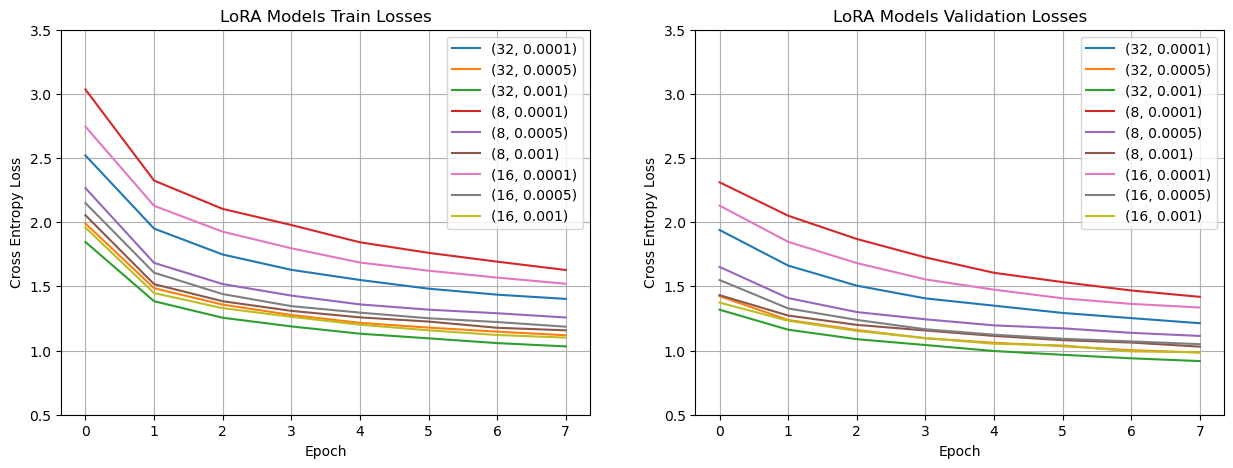

In [188]:
r_lr_train_loss = np.zeros((8, 9))
r_lr_dev_loss = np.zeros((8, 9))
ranks_lrs = []
for i in range(9):
    ranks_lrs.append((LoRA_model_lst[i]['rank'], LoRA_model_lst[i]['lr']))
    r_lr_train_loss[:, i] = LoRA_model_lst[i]['train_losses']
    r_lr_dev_loss[:, i] = LoRA_model_lst[i]['dev_losses']

# plot the cross entropy losses against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(r_lr_train_loss)
ax[0].set_title('LoRA Models Train Losses')
ax[1].plot(r_lr_dev_loss)
ax[1].set_title('LoRA Models Validation Losses')

# common features
for i in range(2):
    ax[i].legend(ranks_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Cross Entropy Loss')
    ax[i].set_ylim([0.5,3.5])
    ax[i].grid()

plt.show()

In [38]:
def set_only_last_n_layers_trainable(t5_model, n):
    """
    Function to set the parameters in the last n attention layers in the decoder module, the embedding layer 
    and the final layer normalization of an ordinary T5 model to be trainable, freeze all other parameters
    
    Parameters:
    t5_model T5ForConditionalGeneration: The T5 model whose parameters to be set trainable or untrainable
    n int: the number of decoder attention layers to be set
    
    """
    new_model = copy.deepcopy(t5_model)
    from_layer_n = 5-(n-1)
    #print(r"decoder\.block\.["+str(from_layer_n)+r"-5]\.layer.*")
    param_name_pattern = re.compile(r"decoder\.block\.["+str(from_layer_n)+r"-5]\.layer.*")
    
    for name,param in new_model.named_parameters():
        if (re.match(param_name_pattern,name) 
            or name == 'shared.weight'
            or name == 'decoder.final_layer_norm.weight'):
            param.requires_grad = True
        else:
            param.requires_grad = False
    
    return new_model

In [39]:
baseline_cand_lrs = [1e-4, 2e-4, 3e-4]
baseline_model_lst = []

for lr in baseline_cand_lrs:
    model_file_path = './Baseline_'+str(lr)+'.pt'
    # Finetune T5 model with the last two layers of the decoder module set to be trainable
    #adapted_model = copy.deepcopy(transferred_model)
    baseline_model = set_only_last_n_layers_trainable(model, 2)
    print("Finetuning T5 model with only last 2 decoder layers trainable with learning rate: %s"%(str(lr)))
        
    train_losses, dev_losses = train(baseline_model, inst_to_code_train_dataset, inst_to_code_dev_dataset,
                                     batch_size=8, learning_rate=lr, num_of_epochs=8,
                                     save_to_file=model_file_path)

    baseline_model_dict = {'lr':lr, 'fine-tuned model':baseline_model,
                            'train_losses':train_losses, 'dev_losses':dev_losses}
        
    baseline_model_lst.append(baseline_model_dict)

Finetuning T5 model with only last 2 decoder layers trainable with learning rate: 0.0001


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [04:22<00:00,  1.07it/s]


epoch 0: train loss :: 3.068, dev loss :: 2.219


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


epoch 1: train loss :: 2.231, dev loss :: 1.864


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:53<00:00,  1.20it/s]


epoch 2: train loss :: 2.008, dev loss :: 1.662


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [04:08<00:00,  1.13it/s]


epoch 3: train loss :: 1.838, dev loss :: 1.535


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [04:01<00:00,  1.16it/s]


epoch 4: train loss :: 1.724, dev loss :: 1.448


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:36<00:00,  1.30it/s]


epoch 5: train loss :: 1.645, dev loss :: 1.382


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:20<00:00,  1.40it/s]


epoch 6: train loss :: 1.593, dev loss :: 1.330


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:43<00:00,  1.26it/s]


epoch 7: train loss :: 1.541, dev loss :: 1.290
Finetuning T5 model with only last 2 decoder layers trainable with learning rate: 0.0002


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:11<00:00,  1.47it/s]


epoch 0: train loss :: 2.679, dev loss :: 1.883


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:01<00:00,  1.55it/s]


epoch 1: train loss :: 1.935, dev loss :: 1.552


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:53<00:00,  1.20it/s]


epoch 2: train loss :: 1.709, dev loss :: 1.393


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:28<00:00,  1.35it/s]


epoch 3: train loss :: 1.569, dev loss :: 1.300


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:20<00:00,  1.40it/s]


epoch 4: train loss :: 1.489, dev loss :: 1.238


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:36<00:00,  1.30it/s]


epoch 5: train loss :: 1.422, dev loss :: 1.186


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:19<00:00,  1.41it/s]


epoch 6: train loss :: 1.363, dev loss :: 1.148


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


epoch 7: train loss :: 1.308, dev loss :: 1.119
Finetuning T5 model with only last 2 decoder layers trainable with learning rate: 0.0003


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:36<00:00,  1.30it/s]


epoch 0: train loss :: 2.459, dev loss :: 1.702


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:34<00:00,  1.31it/s]


epoch 1: train loss :: 1.784, dev loss :: 1.406


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:19<00:00,  1.41it/s]


epoch 2: train loss :: 1.572, dev loss :: 1.283


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:19<00:00,  1.41it/s]


epoch 3: train loss :: 1.451, dev loss :: 1.199


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:17<00:00,  1.42it/s]


epoch 4: train loss :: 1.355, dev loss :: 1.141


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:23<00:00,  1.38it/s]


epoch 5: train loss :: 1.300, dev loss :: 1.097


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:07<00:00,  1.50it/s]


epoch 6: train loss :: 1.253, dev loss :: 1.062


eval: 100%|██████████████████████████████████████████████████████████████████████████| 281/281 [03:36<00:00,  1.30it/s]


epoch 7: train loss :: 1.217, dev loss :: 1.034


In [52]:
for baseline_model in baseline_model_lst:
    if next(baseline_model['fine-tuned model'].parameters()).is_cuda:
        baseline_model['fine-tuned model'].to(torch.device("cpu"))
gc.collect()
torch.cuda.empty_cache()

867916800
False
867916800
False
False
867916800
False
False
867916800
False


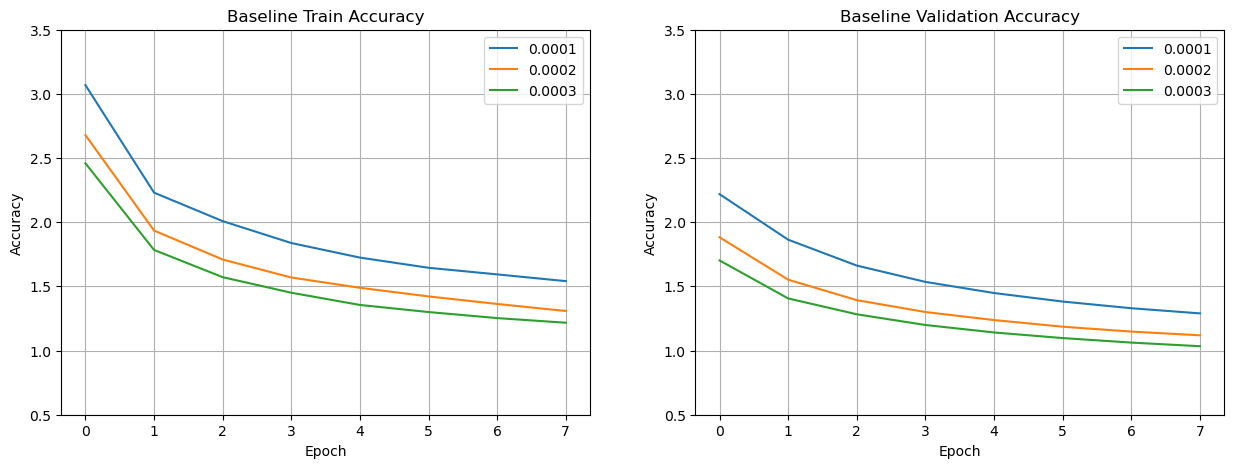

In [82]:
baseline_lr_train_loss = np.zeros((8, 3))
baseline_lr_dev_loss = np.zeros((8, 3))
for i in range(3):
    baseline_lr_train_loss[:, i] = baseline_model_lst[i]['train_losses']
    baseline_lr_dev_loss[:, i] = baseline_model_lst[i]['dev_losses']

# plot the accuracies against the number of epochs for different learning rate values
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(baseline_lr_train_loss)
ax[0].set_title('Baseline Models Train Losses')
ax[1].plot(baseline_lr_dev_loss)
ax[1].set_title('Baseline Models Validation Losses')

# common features
for i in range(2):
    ax[i].legend(baseline_cand_lrs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Cross Entropy Loss')
    ax[i].set_ylim([0.5,3.5])
    ax[i].grid()

plt.show()

In [54]:
def load_lora_state_dict(lora_parameters, base_t5_model):
    """
        Load a state dict into the model from a specified file path or a state dict directly.
        This is a staticmethod to be used from the base clase, returning a fully initialized and LoRA loaded model.

        Parameters:
        lora_parameters str/Path/dict
            Either the file path to the state dict (can be a string or pathlib.Path) or the state dict itself. If a file path
            is provided, the function will load the state dict from the file. If a state dict is provided directly, the function
            will use it as is.

        Output:
        LoraWrapperT5 object, initialized and with the LoRA and other trainable parameters loaded.
    """
    # Check if a filepath or state dict was provided
    if lora_parameters is not None:
        # Convert string to pathlib.Path if necessary
        if isinstance(lora_parameters, str):
            lora_parameters = Path(lora_parameters)

        # If the provided object is a Path, load the state dict from file
        if isinstance(lora_parameters, Path):
            state_dict = torch.load(lora_parameters)
        else:
            # If it's not a Path, assume it's a state dict
            state_dict = lora_parameters
    else:
        raise ValueError("No filepath or state dict provided")

    Lora_T5_model = LoraWrapperT5(t5_model= base_t5_model,lora_enc_dec_or_both = state_dict['lora_enc_dec_or_both'], 
                                  lora_rank = state_dict['lora_rank'], train_biases = state_dict['train_biases'],
                                  train_embedding = state_dict['train_embeddings'], 
                                  train_layer_norms = state_dict['train_layer_norms'])

    # Load the state dict into the model
    Lora_T5_model.load_state_dict(state_dict, strict=False)

    return Lora_T5_model

## Model Evaluation

In [209]:
def corpus_level_bleu_score(references, generated_seq) -> float:
    """ 
    Function to compute corpus-level BLEU score, given encoder decoder model outputs and groud-truth target text sequences
    
    Parameters:
    references (Tensor[Tensor[int]]): a list of groud-truth target text sequences in list of their tokens' ids
    generated_seq (Tensor[Tensor[int]]): a list of generated text sequence, one for each target sentence, in list of their tokens' ids
    
    Outputs:
    bleu_score float: corpus-level BLEU score computed using nltk.translate.bleu_score.corpus_bleu
    """
    
    ref_eos_indices = [list(ref).index(1) for ref in references]
    gen_seq_eos_indices = [list(seq).index(1) if (1 in seq) else len(seq) for seq in generated_seq]
    #print(len(generated_seq))
    #print(len(gen_seq_eos_indices))

    truncated_refs = [ref[:eos_token_idx] for ref,eos_token_idx in zip(list(references),ref_eos_indices)]
    truncated_gen_seq = [seq[1:eos_token_idx] for seq,eos_token_idx in zip(list(generated_seq),gen_seq_eos_indices)]
    token_refs = [tokenizer.convert_ids_to_tokens(ref) for ref in truncated_refs]
    token_gen_seq = [tokenizer.convert_ids_to_tokens(seq) for seq in truncated_gen_seq]
    #print(truncated_refs)
    #print(truncated_gen_seq)
    #print(len(token_refs))
    #print(len(token_gen_seq))
    bleu_score = corpus_bleu([[ref] for ref in token_refs],token_gen_seq)
    return bleu_score

In [176]:
def model_eval(QAmodel, test_dataset, batch_size):
    """
    Function to evaluate a finetuned T5 or LoraWrapperT5 model with a test dataset using corpus-level BLEU score as the metric
    
    Parameters:
    QAmodel: the finetuned T5 or LoraWrapperT5 model to be evaluated 
    test_dataset: the test dataset to be used in the evaluation
    batch_size: size of batches which the test data will be loaded with 
    
    Outputs: Average batch BLEU score over the whole test dataset
    """
    # Put model into the device
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    QAmodel = QAmodel.to(device)
    
    # switch to eval model to turn off dropout and
    # keep gradients from flowing back to update parameters
    model_was_training = False
    if QAmodel.training:
        model_was_training = True
        QAmodel.eval()
        
    num_batches = 0
    test_bleu_score = 0
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size,
                             collate_fn=test_dataset.collate_fn, drop_last=True)
    
    for step, batch in enumerate(tqdm(test_loader, desc=f'test', disable=False)):
        b_q_token_ids, b_a_token_ids = (batch['q_token_ids'], batch['a_token_ids'])

        b_q_token_ids = b_q_token_ids.to(device)

        #print(b_q_token_ids.size())
        gen_outputs = QAmodel.generate(input_ids=b_q_token_ids,max_new_tokens=b_a_token_ids.size()[1], do_sample=False)
        batch_bleu_score = corpus_level_bleu_score(b_a_token_ids, gen_outputs)
        test_bleu_score += batch_bleu_score
        num_batches += 1
        
        del b_q_token_ids
        gc.collect()
        torch.cuda.empty_cache()

    # Avg BLEU score across batches
    test_bleu_score = test_bleu_score / (num_batches)
    
    if model_was_training:
        QAmodel.train()
    
    return test_bleu_score

In [192]:
final_baseline_model = copy.deepcopy(model)
final_baseline_model.load_state_dict(torch.load('Baseline_0.0003.pt'))

<All keys matched successfully>

In [210]:
lora_test_bleu = model_eval(LoRA_model_lst[2]['fine-tuned model'], inst_to_code_test_dataset,16)

test: 100%|██████████████████████████████████████████████████████████████████████████| 140/140 [18:38<00:00,  7.99s/it]


In [211]:
baseline_test_bleu = model_eval(final_baseline_model, inst_to_code_test_dataset,16)

test: 100%|██████████████████████████████████████████████████████████████████████████| 140/140 [16:54<00:00,  7.25s/it]


In [212]:
print("Average BLEU score of model with LoRA on test set: %.6f)"%lora_test_bleu)

Average BLEU score of model with LoRA on test set: 0.081067)


In [213]:
print("Average BLEU score of baseline model on test set: %.6f)"%baseline_test_bleu)

Average BLEU score of baseline model on test set: 0.064016)
